<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#加载数据和模型" data-toc-modified-id="加载数据和模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>加载数据和模型</a></span></li><li><span><a href="#精度，召回率，F和时间随参数的变化" data-toc-modified-id="精度，召回率，F和时间随参数的变化-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>精度，召回率，F和时间随参数的变化</a></span><ul class="toc-item"><li><span><a href="#随MAX_DIS变化" data-toc-modified-id="随MAX_DIS变化-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>随MAX_DIS变化</a></span></li><li><span><a href="#随MAX_ANGLE变化" data-toc-modified-id="随MAX_ANGLE变化-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>随MAX_ANGLE变化</a></span></li><li><span><a href="#随MIN_LEN变化" data-toc-modified-id="随MIN_LEN变化-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>随MIN_LEN变化</a></span></li><li><span><a href="#随MIN_COVER_ANGLE变化" data-toc-modified-id="随MIN_COVER_ANGLE变化-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>随MIN_COVER_ANGLE变化</a></span></li><li><span><a href="#随MIN_COVER_RHO1变化" data-toc-modified-id="随MIN_COVER_RHO1变化-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>随MIN_COVER_RHO1变化</a></span></li><li><span><a href="#随MIN_COVER_RHO2变化" data-toc-modified-id="随MIN_COVER_RHO2变化-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>随MIN_COVER_RHO2变化</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline
raw_path = r'/home/liucc/Workspace/02_Ellipse/03_results/01_industry/01_raw/'
label_path = r'/home/liucc/Workspace/02_Ellipse/03_results/01_industry/04_ellipse_label/'

In [2]:
import os 
fnames = os.listdir(raw_path)
fnames = [n[:-4] for n in fnames if n[-3:]=='jpg']
fnames.sort()
print(fnames[:10])

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010']


# 加载数据和模型

In [3]:
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/01_data')
from cc_process_image import *
import imageio

raws = get_all_images(f'{raw_path}',fnames,'jpg')

print(len(raws))

/home/liucc/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


66


In [4]:
gts = []

for name in fnames:
    lname = label_path+name+'.txt'
    
    with open(lname,'r') as f:
        txt = f.read()
        
        ells_t = [[float(v) for v in l.split(' ')] for l in txt.split('\n')]
        
        gts.append(ells_t)
        

print(len(gts))

66


In [5]:
sys.path.append('/home/liucc/Workspace/02_Ellipse/02_algorithm/01_cnn')
from cnn_model import *

model_path = r'/home/liucc/Workspace/02_Ellipse/06_model/'
model_name = r'ellipse-2'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = RestoreNet().to(device)

model.load_state_dict(torch.load(f'{model_path}{model_name}.mdl')['state_dict'])

# 精度，召回率，F和时间随参数的变化

In [6]:
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/02_algorithm/02_ellipse_detect')
from cc_ellipse_v2 import *
from experiment import *

In [7]:
import time


def one_task(glob):
    start = time.time()

    prs = []
    
    for im in raws:
        im = preprocess_image(im)
        imo = predict(model,im, device)
        imo = postprocess_image(imo,thr=0.5)
        ells = detect_ellipses_im(imo,glob)
        
        prs.append(ells)

    end = time.time()
    
    costT = (end-start)/len(raws)
    
    precision,recall,F1,_,_ = cal_metrics(prs,gts)
    
    #print(precision,recall,F1,costT)
    
    return [precision,recall,F1,costT]

In [16]:
#全局参数
GLOB = {
    'MAX_FIT_DIS':4,
    'MAX_DIS':0,
    'MAX_ANGLE':40,
    'MIN_LEN' : 20,
    'MIN_COVER_ANGLE' : 120,
    'MIN_COVER_RHO1' : 0.4,
    'MIN_COVER_RHO2' : 0.3,
}
one_task(GLOB)

[0.8164915117219078,
 0.7122708039492243,
 0.7608286252354048,
 0.4988617824785637]

## 随MAX_DIS变化

In [9]:
from matplotlib.font_manager import FontProperties
fp1 = FontProperties(family="DejaVu Sans",size=20)
fp2 = FontProperties(family="DejaVu Sans",size=18)

GLOB = {
    'MAX_FIT_DIS':4,
    'MAX_DIS':0,
    'MAX_ANGLE':45,
    'MIN_LEN' : 20,
    'MIN_COVER_ANGLE' : 90,
    'MIN_COVER_RHO1' : 0.0,
    'MIN_COVER_RHO2' : 0.0,
}

res01 = []
xs01 = list(range(0,40,10))
for x in xs01:
    GLOB['MAX_DIS'] = x
    res = one_task(GLOB)
    res01.append(res)
    print(f'{x}:{res}')

0:[0.6433353621424224, 0.7454160789844851, 0.6906239790918, 0.6107873699881814]
10:[0.6429440389294404, 0.7454160789844851, 0.6903984323971261, 0.5900549671866677]
20:[0.6408237431859479, 0.7461212976022567, 0.6894753991528184, 0.5671756448167743]
30:[0.6357615894039735, 0.7447108603667136, 0.6859369925300423, 0.5132478475570679]


## 随MAX_ANGLE变化

In [10]:
from matplotlib.font_manager import FontProperties
fp1 = FontProperties(family="DejaVu Sans",size=20)
fp2 = FontProperties(family="DejaVu Sans",size=18)

GLOB = {
    'MAX_FIT_DIS':4,
    'MAX_DIS':0,
    'MAX_ANGLE':40,
    'MIN_LEN' : 20,
    'MIN_COVER_ANGLE' : 90,
    'MIN_COVER_RHO1' : 0.0,
    'MIN_COVER_RHO2' : 0.0,
}

res02 = []
xs02 = list(range(30,90,10))
for x in xs02:
    GLOB['MAX_ANGLE'] = x
    res = one_task(GLOB)
    res02.append(res)
    print(f'{x}:{res}')

30:[0.639294403892944, 0.7411847672778561, 0.6864794252122796, 0.5826516657164602]
40:[0.6433353621424224, 0.7454160789844851, 0.6906239790918, 0.5844019687536991]
50:[0.6429440389294404, 0.7454160789844851, 0.6903984323971261, 0.5833594257181342]
60:[0.6416464891041163, 0.7475317348377997, 0.6905537459283387, 0.5935406143015082]
70:[0.6389891696750902, 0.7489421720733427, 0.6896103896103896, 0.6092758106462883]
80:[0.6332138590203107, 0.7475317348377997, 0.685640362225097, 0.6109247027021466]


## 随MIN_LEN变化

In [15]:
from matplotlib.font_manager import FontProperties
fp1 = FontProperties(family="DejaVu Sans",size=20)
fp2 = FontProperties(family="DejaVu Sans",size=18)

GLOB = {
    'MAX_FIT_DIS':4,
    'MAX_DIS':0,
    'MAX_ANGLE':40,
    'MIN_LEN' : 20,
    'MIN_COVER_ANGLE' : 120,
    'MIN_COVER_RHO1' : 0.4,
    'MIN_COVER_RHO2' : 0.3,
}

res1 = []
xs1 = list(range(10,50,10))
for x in xs1:
    GLOB['MIN_LEN'] = x
    res = one_task(GLOB)
    res1.append(res)
    print(f'{x}:{res}')

10:[0.8107457898957497, 0.7129760225669958, 0.7587242026266416, 0.5003388289249304]
20:[0.8164915117219078, 0.7122708039492243, 0.7608286252354048, 0.4990224874380863]
30:[0.8381706244503079, 0.6720733427362482, 0.7459882583170254, 0.49774192680012097]
40:[0.8688193743693239, 0.6071932299012694, 0.7148194271481941, 0.4958252256566828]


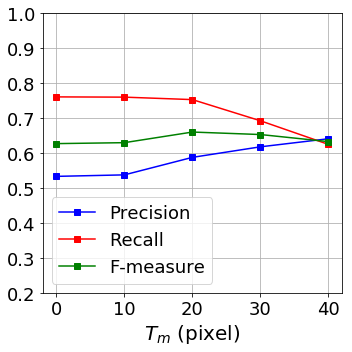

In [10]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np

res1 = np.array(res1)

fig = plt.figure(figsize=(5,5))

plt.plot(xs1,res1[:,0],'bs-',label='Precision')
plt.plot(xs1,res1[:,1],'rs-',label='Recall')
plt.plot(xs1,res1[:,2],'gs-',label='F-measure')

plt.xlabel('$T_m$ (pixel)',fontproperties=fp1)
plt.xticks(xs1,fontproperties=fp2)
plt.yticks(fontproperties=fp2)
plt.legend(prop=fp2)
plt.ylim((0.2,1))
plt.grid()
plt.tight_layout()
plt.show()

pp = PdfPages('images/Tm_metric.pdf')
pp.savefig(fig)
pp.close()

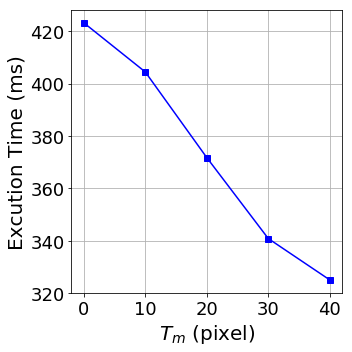

In [11]:
fig = plt.figure(figsize=(5,5))

plt.xlabel('$T_m$ (pixel)',fontproperties=fp1)
plt.ylabel('Excution Time (ms)',fontproperties=fp1)

plt.xticks(xs1,fontproperties=fp2)
plt.yticks(fontproperties=fp2)

plt.plot(xs1,res1[:,3]*1000,'bs-')
plt.grid()
plt.tight_layout()
plt.show()

pp = PdfPages('images/Tm_time.pdf')
pp.savefig(fig)
pp.close()

## 随MIN_COVER_ANGLE变化

In [12]:
GLOB = {
    'MAX_FIT_DIS':4,
    'MAX_DIS':0,
    'MAX_ANGLE':40,
    'MIN_LEN' : 20,
    'MIN_COVER_ANGLE' : 120,
    'MIN_COVER_RHO1' : 0.0,
    'MIN_COVER_RHO2' : 0.0,
}

res2 = []
xs2 = np.arange(60,181,20)
for x in xs2:
    GLOB['MIN_COVER_ANGLE'] = x
    res = one_task(GLOB)
    res2.append(res)
    print(f'{x}:{res}')

60:[0.5701943844492441, 0.7447108603667136, 0.6458715596330276, 0.5921884739037716]
80:[0.6182136602451839, 0.7468265162200282, 0.6764611945065474, 0.5871176322301229]
100:[0.6666666666666666, 0.7433004231311706, 0.7029009669889964, 0.5898111986391472]
120:[0.7105978260869565, 0.7376586741889986, 0.7238754325259515, 0.5933159192403158]
140:[0.7379061371841156, 0.7207334273624824, 0.729218694256154, 0.49879300233089563]
160:[0.7692895339954163, 0.7101551480959097, 0.7385405207187385, 0.4940578142801921]
180:[0.7948511665325825, 0.6967559943582511, 0.7425779782036829, 0.4907909595605099]


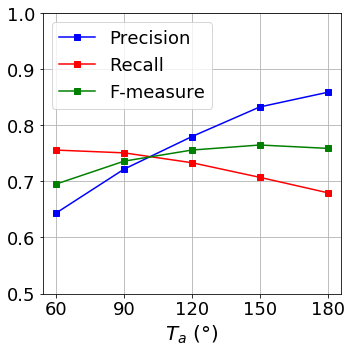

In [13]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np

res2 = np.array(res2)

fig = plt.figure(figsize=(5,5))

plt.plot(xs2,res2[:,0],'bs-',label='Precision')
plt.plot(xs2,res2[:,1],'rs-',label='Recall')
plt.plot(xs2,res2[:,2],'gs-',label='F-measure')

plt.xlabel('$T_a$ (°)',fontproperties=fp1)
plt.xticks(xs2,fontproperties=fp2)
plt.yticks(fontproperties=fp2)
plt.legend(prop=fp2)
plt.ylim((0.5,1))
plt.grid()
plt.tight_layout()
plt.show()

pp = PdfPages('images/Ta_metric.pdf')
pp.savefig(fig)
pp.close()

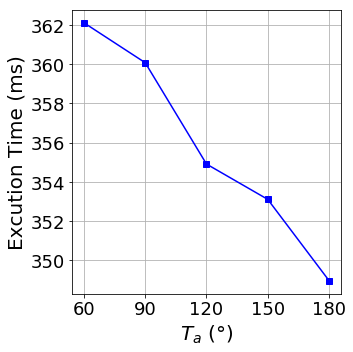

In [14]:
fig = plt.figure(figsize=(5,5))

plt.xlabel('$T_a$ (°)',fontproperties=fp1)
plt.ylabel('Excution Time (ms)',fontproperties=fp1)

plt.xticks(xs2,fontproperties=fp2)
plt.yticks(fontproperties=fp2)

plt.plot(xs2,res2[:,3]*1000,'bs-')
plt.grid()
plt.tight_layout()
plt.show()

pp = PdfPages('images/Ta_time.pdf')
pp.savefig(fig)
pp.close()

## 随MIN_COVER_RHO1变化

In [13]:
GLOB = {
    'MAX_FIT_DIS':4,
    'MAX_DIS':0,
    'MAX_ANGLE':40,
    'MIN_LEN' : 20,
    'MIN_COVER_ANGLE' : 120,
    'MIN_COVER_RHO1' : 0.4,
    'MIN_COVER_RHO2' : 0.0,
}

res3 = []
xs3 = np.arange(0.3,0.7,0.1)
for x in xs3:
    GLOB['MIN_COVER_RHO1'] = x
    res = one_task(GLOB)
    res3.append(res)
    print(f'{x}:{res}')

0.3:[0.7405559515324305, 0.732722143864598, 0.7366182204891881, 0.4994639916853471]
0.4:[0.763335837716003, 0.7165021156558533, 0.7391778828664968, 0.5401353402571245]
0.5:[0.7887096774193548, 0.689703808180536, 0.7358916478555305, 0.5074465816671198]
0.6000000000000001:[0.8077617328519856, 0.6311706629055007, 0.7086302454473477, 0.4982499931797837]


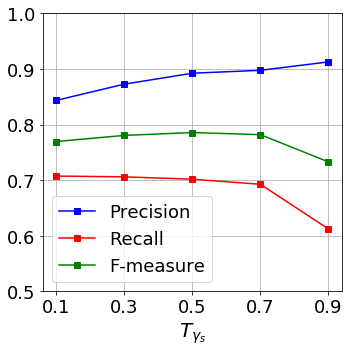

In [17]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np

res3 = np.array(res3)

fig = plt.figure(figsize=(5,5))

plt.plot(xs3,res3[:,0],'bs-',label='Precision')
plt.plot(xs3,res3[:,1],'rs-',label='Recall')
plt.plot(xs3,res3[:,2],'gs-',label='F-measure')

plt.xlabel('$T_{\gamma_s}$',fontproperties=fp1)
plt.xticks(xs3,fontproperties=fp2)
plt.yticks(fontproperties=fp2)
plt.legend(prop=fp2)
plt.ylim((0.5,1))
plt.grid()
plt.tight_layout()
plt.show()

pp = PdfPages('images/Tr1_metric.pdf')
pp.savefig(fig)
pp.close()

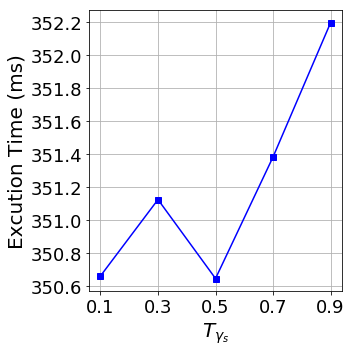

In [18]:
fig = plt.figure(figsize=(5,5))

plt.xlabel('$T_{\gamma_s}$',fontproperties=fp1)
plt.ylabel('Excution Time (ms)',fontproperties=fp1)

plt.xticks(xs3,fontproperties=fp2)
plt.yticks(fontproperties=fp2)

plt.plot(xs3,res3[:,3]*1000,'bs-')
plt.grid()
plt.tight_layout()
plt.show()

pp = PdfPages('images/Tr1_time.pdf')
pp.savefig(fig)
pp.close()

## 随MIN_COVER_RHO2变化

In [14]:
GLOB = {
    'MAX_FIT_DIS':4,
    'MAX_DIS':0,
    'MAX_ANGLE':40,
    'MIN_LEN' : 20,
    'MIN_COVER_ANGLE' : 120,
    'MIN_COVER_RHO1' : 0.4,
    'MIN_COVER_RHO2' : 0.3,
}


res4 = []
xs4 = np.arange(0,0.6,0.1)
for x in xs4:
    GLOB['MIN_COVER_RHO2'] = x
    res = one_task(GLOB)
    res4.append(res)
    print(f'{x}:{res}')

0.0:[0.763335837716003, 0.7165021156558533, 0.7391778828664968, 0.4993954933050907]
0.1:[0.763335837716003, 0.7165021156558533, 0.7391778828664968, 0.49980469905968866]
0.2:[0.7732115677321156, 0.7165021156558533, 0.7437774524158125, 0.4993812893376206]
0.30000000000000004:[0.8164915117219078, 0.7122708039492243, 0.7608286252354048, 0.49948436202424945]
0.4:[0.8875119161105816, 0.656558533145275, 0.7547628698824482, 0.4996159907543298]
0.5:[0.9523809523809523, 0.5500705218617772, 0.697362539114886, 0.4993969996770223]


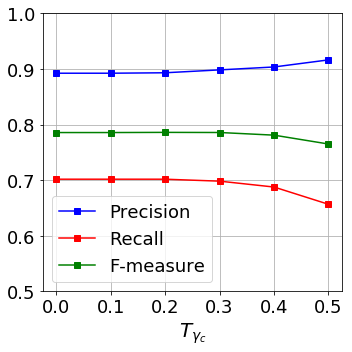

In [20]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np

res4 = np.array(res4)

fig = plt.figure(figsize=(5,5))

plt.plot(xs4,res4[:,0],'bs-',label='Precision')
plt.plot(xs4,res4[:,1],'rs-',label='Recall')
plt.plot(xs4,res4[:,2],'gs-',label='F-measure')

plt.xlabel('$T_{\gamma_c}$',fontproperties=fp1)
plt.xticks(xs4,fontproperties=fp2)
plt.yticks(fontproperties=fp2)
plt.legend(prop=fp2)
plt.ylim((0.5,1))
plt.grid()
plt.tight_layout()
plt.show()

pp = PdfPages('images/Tr2_metric.pdf')
pp.savefig(fig)
pp.close()

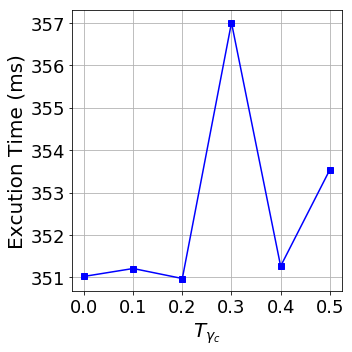

In [21]:
fig = plt.figure(figsize=(5,5))

plt.xlabel('$T_{\gamma_c}$',fontproperties=fp1)
plt.ylabel('Excution Time (ms)',fontproperties=fp1)

plt.xticks(xs4,fontproperties=fp2)
plt.yticks(fontproperties=fp2)

plt.plot(xs4,res4[:,3]*1000,'bs-')
plt.grid()
plt.tight_layout()
plt.show()

pp = PdfPages('images/Tr2_time.pdf')
pp.savefig(fig)
pp.close()